In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import math

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import pvlib

import gsee

In [3]:
locations = {'athens': [37.9838, 23.7275], 'davos': [46.8027, 9.8360], 'stockholm': [59.3293, 18.0686], 'wurzburg': [49.7913, 9.9534]}
tilts = {'athens': 25, 'davos': 30, 'stockholm': 45, 'wurzburg': 35}
techs = ["fp1", "fp2", "fp3", "et1", "et2", "et3"]
dataset = 'merra2'
interpolate = True
flexible_boundary = True
fluid_temperature = 75
tilt = 25
azimuth = 180
system_loss = 0.1
raw = False
technology = "fp2"

def _get_var(src_data, lat, lon):
    return src_data.loc[{'lat': lat, 'lon': lon}].to_series()

In [4]:
years = range(2000, 2001)
data_dirs = ["SWGDN", "SWTDN", "T2M"]
src_data = {'merra2': xr.merge([
    xr.concat([
        xr.open_dataset(f'/cluster/work/cpesm/ninjadata/merra2/{i.lower()}/{j}.nc')
        .interp(lat=[l[0] for l in locations.values()], lon=[l[1] for l in locations.values()])
        for j in years
    ], dim='time')
    for i in data_dirs
])}

In [5]:
solposition = pvlib.solarposition.get_solarposition(
    time=src_data["merra2"].time.to_index(), latitude=49.7913, longitude=9.9534
)
dni = pvlib.irradiance.dni(
    ghi=ghi, dhi=ghi * (1 - diff_frac), zenith=solposition['apparent_zenith']
)
total_irradiation = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,
    surface_azimuth=azimuth,
    solar_zenith=solposition['apparent_zenith'],
    solar_azimuth=solposition['azimuth'],
    dni=dni.fillna(0),  # fill NaN values with '0'
    ghi=ghi,
    dhi=ghi * (1 - diff_frac),
)
foo = gsee.thermal.EvacuatedtubePanel(tech_characteristics.et1)
out2 = foo.panel_capacity(
    data.temperature,
    75,
    total_irradiation.poa_direct.fillna(0),
    total_irradiation.poa_diffuse.fillna(0),
    gsee_irrad.incidence,
    new_angles.angleT,
    new_angles.angleL
)

In [19]:
location_name = 'wurzburg'
coords = [49.7913, 9.9534]
lat, lon = coords
ghi = _get_var(src_data[dataset]['SWGDN'], lat, lon)
swtdn = _get_var(src_data[dataset]['SWTDN'], lat, lon)  # W
# Run BRL model to get diffuse fraction
clearness = ghi / swtdn
rise_set_times = gsee.trigon.sun_rise_set_times(ghi.index, [lat, lon])
diff_frac = gsee.brl_model.run(clearness, [lat, lon], rise_set_times)
angles = gsee.trigon.sun_angles(ghi.index, [lat, lon], rise_set_times)

gsee_irrad = gsee.trigon.aperture_irradiance(
    ghi * (1 - diff_frac), ghi * diff_frac, coords, math.radians(tilt), math.radians(azimuth),
    tracking=0, angles=angles
)
new_angles = gsee.trigon.incident_angle_modifier(
    angles["sun_zenith"],
    angles["sun_azimuth"],
    math.radians(azimuth),
    math.radians(tilt),
    gsee_irrad["incidence"],
)
foo = gsee.thermal.EvacuatedtubePanel(tech_characteristics.et1)
out = foo.panel_capacity(
    data.temperature,
    75,
    gsee_irrad.direct,
    gsee_irrad.diffuse,
    gsee_irrad.incidence,
    new_angles.angleT,
    new_angles.angleL
)

In [97]:
np.rad2deg(gsee_irrad.incidence.head(24))

time
2000-01-01 00:30:00    115.000000
2000-01-01 01:30:00    115.000000
2000-01-01 02:30:00    115.000000
2000-01-01 03:30:00    115.000000
2000-01-01 04:30:00    115.000000
2000-01-01 05:30:00    115.000000
2000-01-01 06:30:00    115.000000
2000-01-01 07:30:00     72.219188
2000-01-01 08:30:00     59.060212
2000-01-01 09:30:00     51.877646
2000-01-01 10:30:00     48.114707
2000-01-01 11:30:00     48.587182
2000-01-01 12:30:00     53.181642
2000-01-01 13:30:00     60.955881
2000-01-01 14:30:00     70.774796
2000-01-01 15:30:00     76.644469
2000-01-01 16:30:00    115.000000
2000-01-01 17:30:00    115.000000
2000-01-01 18:30:00    115.000000
2000-01-01 19:30:00    115.000000
2000-01-01 20:30:00    115.000000
2000-01-01 21:30:00    115.000000
2000-01-01 22:30:00    115.000000
2000-01-01 23:30:00    115.000000
Name: incidence, dtype: float64

In [99]:
solposition.head(24)

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
time,,,,,,
2000-01-01 00:30:00,150.249324,150.249324,-60.249324,-60.249324,32.169354,-3.053598
2000-01-01 01:30:00,143.577969,143.577969,-53.577969,-53.577969,54.477386,-3.073476
2000-01-01 02:30:00,134.968198,134.968198,-44.968198,-44.968198,71.099876,-3.093347
2000-01-01 03:30:00,125.521242,125.521242,-35.521242,-35.521242,84.321149,-3.113209
2000-01-01 04:30:00,115.854922,115.854922,-25.854922,-25.854922,95.791821,-3.133063
2000-01-01 05:30:00,106.370453,106.370453,-16.370453,-16.370453,106.544011,-3.152909
2000-01-01 06:30:00,97.398222,97.398222,-7.398222,-7.398222,117.260500,-3.172747
2000-01-01 07:30:00,88.881759,89.270691,1.118241,0.729309,128.431640,-3.192577
2000-01-01 08:30:00,82.243119,82.357107,7.756881,7.642893,140.405495,-3.212399


In [93]:
solpositionclip(lower=0).capacity.where(lambda x: x > 0).dropna().sum()

686184.1365129878

In [94]:
out2.clip(lower=0).capacity.where(lambda x: x > 0).dropna().sum()

614927.0534239828

In [29]:
total_irradiation.poa_global.sum()

1508293.551686412

In [16]:
np.rad2deg(angles.sun_azimuth).where(lambda x: (x < 90) & (x > 0)).dropna()

time
2000-03-27 05:30:00    89.780282
2000-03-28 05:30:00    89.379473
2000-03-29 05:30:00    88.977974
2000-03-30 05:30:00    88.579050
2000-03-31 04:30:00    82.463879
                         ...    
2000-09-13 04:30:00    83.899592
2000-09-14 04:30:00    84.354797
2000-09-15 04:30:00    84.812706
2000-09-16 04:30:00    85.270049
2000-09-17 04:30:00    85.728341
Name: sun_azimuth, Length: 401, dtype: float64

In [33]:
gsee_global_normal = (caps.direct + caps.diffuse).sum() 
pvlib_global_normal = total_irradiation.poa_global.sum()
gsee_global_normal / pvlib_global_normal

1.0615327783103692

In [107]:
gsee_direct_normal = wurzburg_raw.direct.sum()
pvlib_direct_normal = total_irradiation.poa_direct.sum()
gsee_direct_normal / pvlib_direct_normal

1.5939827993726357

In [109]:
gsee_diffuse_normal = wurzburg_raw.diffuse.sum()
pvlib_diffuse_normal = total_irradiation.poa_diffuse.sum()
gsee_diffuse_normal / pvlib_diffuse_normal

0.6183707787528469

In [72]:
location_name = 'wurzburg'
coords = [49.7913, 9.9534]
lat, lon = coords
ghi = _get_var(src_data[dataset]['SWGDN'], lat, lon)
swtdn = _get_var(src_data[dataset]['SWTDN'], lat, lon)  # W
# Run BRL model to get diffuse fraction
clearness = ghi / swtdn
rise_set_times = gsee.trigon.sun_rise_set_times(ghi.index, [lat, lon])
diff_frac = gsee.brl_model.run(clearness, [lat, lon], rise_set_times)
data = pd.DataFrame({'global_horizontal': ghi,
                     'diffuse_fraction': diff_frac})
# Add temperature data, converting from Kelvin (MERRA) to deg C
data['temperature'] = _get_var(src_data[dataset]['T2M'], lat, lon) - 273.13
angles = gsee.trigon.sun_angles(ghi.index, [lat, lon], rise_set_times)
tech = "et1"
print(f"{location_name}: {tech}")
wurzburg_raw = gsee.thermal.run_model(
    data, coords=[lat, lon], fluid_temperature=fluid_temperature,
    tilt=tilts[location_name], azimuth=azimuth,
    technology=tech, system_loss=system_loss,
    angles=angles, include_raw_data=True,
    #**kwargs
)

wurzburg: et1


In [101]:
ghi.sum()

1365736.5484333835

In [106]:
wurzburg_raw[(wurzburg_raw.index.hour == 7) & (wurzburg_raw.index.month == 7)].head(30)

,capacity,direct,diffuse,temperature
time,,,,
2000-07-01 07:30:00,263.414803,406.882302,136.642639,21.756038
2000-07-02 07:30:00,216.578403,287.456337,189.497488,20.860601
2000-07-03 07:30:00,38.072841,14.387120,179.860463,18.697438
2000-07-04 07:30:00,119.303002,75.523028,256.110900,19.729821
2000-07-05 07:30:00,286.218192,488.976012,96.765345,17.632645
2000-07-06 07:30:00,288.994812,490.074301,95.948263,19.083363
2000-07-07 07:30:00,230.285503,315.530573,184.270373,20.134985
2000-07-08 07:30:00,0.000000,6.236018,140.521055,10.991546
2000-07-09 07:30:00,105.571022,76.856428,248.261550,13.664976


In [34]:
caps = {}
for location_name, coords in locations.items():
    caps[location_name] = pd.DataFrame()
    lat, lon = coords
    ghi = _get_var(src_data[dataset]['SWGDN'], lat, lon)
    swtdn = _get_var(src_data[dataset]['SWTDN'], lat, lon)  # W
    # Run BRL model to get diffuse fraction
    clearness = ghi / swtdn
    rise_set_times = gsee.trigon.sun_rise_set_times(ghi.index, [lat, lon])
    diff_frac = gsee.brl_model.run(clearness, [lat, lon], rise_set_times)
    data = pd.DataFrame({'global_horizontal': ghi,
                         'diffuse_fraction': diff_frac})
    # Add temperature data, converting from Kelvin (MERRA) to deg C
    data['temperature'] = _get_var(src_data[dataset]['T2M'], lat, lon) - 273.13
    angles = gsee.trigon.sun_angles(ghi.index, [lat, lon], rise_set_times)
    for tech in techs:
        print(f"{location_name}: {tech}")
        caps[location_name][tech] = gsee.thermal.run_model(
            data, coords=[lat, lon], fluid_temperature=fluid_temperature,
            tilt=tilts[location_name], azimuth=azimuth,
            technology=tech, system_loss=0,
            angles=angles, include_raw_data=False,
            #**kwargs
        )

athens: fp1
athens: fp2
athens: fp3
athens: et1
athens: et2
athens: et3
davos: fp1
davos: fp2
davos: fp3
davos: et1
davos: et2
davos: et3
stockholm: fp1
stockholm: fp2
stockholm: fp3
stockholm: et1
stockholm: et2
stockholm: et3
wurzburg: fp1
wurzburg: fp2
wurzburg: fp3
wurzburg: et1
wurzburg: et2
wurzburg: et3


In [37]:
tech_characteristics = pd.read_csv("/cluster/work/cpesm/brynmorp/gsee/gsee/thermal_technology_characteristics.csv", index_col=[0, 1], header=0)
performance = tech_characteristics.filter(regex="annual_output_kwh_per_m2_at_75C", axis=0)
performance.index = performance.index.get_level_values('data_type').str.replace("annual_output_kwh_per_m2_at_75C_", "")

In [39]:
df = pd.concat(caps.values(), keys=caps.keys()).unstack(level=0)
df = df.groupby(df.index.year).sum().div(1000)
df_to_plot = df.unstack().rename_axis(index=['tech', 'location', 'year']).to_frame('annual_output').reset_index()

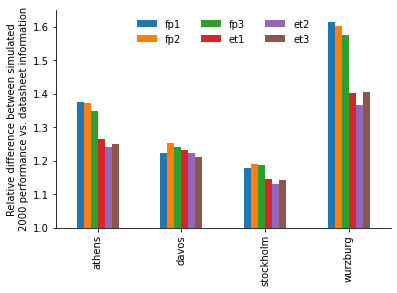

In [71]:
ax = df.loc[2000].div(performance.unstack().astype(float)).unstack(0).plot.bar()
ax.set_ylabel("Relative difference between simulated\n2000 performance vs. datasheet information")
ax.set_ylim(1, 1.65)
ax.legend(loc='upper center', ncol=3, frameon=False)
sns.despine(ax=ax)

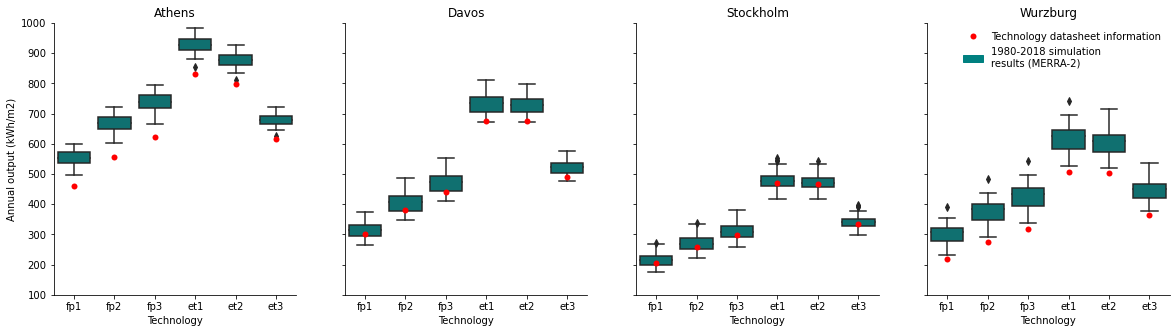

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
_ax = 0

for location in df_to_plot.location.unique():
    sns.boxplot(
        data=df_to_plot[df_to_plot.location == location], 
        x='tech', y='annual_output', 
        ax=ax[_ax], zorder=-1, 
       color='teal'
    )
    ax[_ax].set_title(location.title())
    ax[_ax].set_xlabel('Technology')
    if _ax == 0:
        ax[_ax].set_ylabel('Annual output (kWh/m2)')
    else:
        ax[_ax].set_ylabel('')
    ax[_ax].set_ylim(100,1000)
    foo = ax[_ax].scatter(performance.loc[location].index, performance.loc[location].astype(int).values, lw=0, marker='o', fc='red')    
    sns.despine()
    _ax += 1
ax[-1].legend(
    handles=[
        mpl.lines.Line2D([0], [0], marker='o', color='None', markerfacecolor='red', markeredgecolor='None', label='Technology datasheet information', markersize=6),
        mpl.patches.Polygon([[0, 0], [0, 1], [1, 1], [1, 0]], color='teal', label='1980-2018 simulation\nresults (MERRA-2)')
    ], 
    frameon=False, loc='upper right'
)


In [95]:
performance

,fp1,fp2,fp3,et1,et2,et3
data_type,,,,,,
athens,459,556,624,832,799,616
davos,301,380,442,676,676,490
stockholm,206,258,297,469,468,336
wurzburg,220,275,317,505,503,364
